In [1]:
import os
import zipfile

import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from albumentations import Compose, RandomBrightnessContrast, RandomCrop, Cutout, \
                           HorizontalFlip, Normalize, ShiftScaleRotate

import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm

import matplotlib.pyplot as plt
from pathlib import Path

torch.cuda.set_device('cuda:1')

In [2]:
def show_img(im, figsize=None, ax=None, hide_axis=True):
    if not ax:
        fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.imshow(im)
    if hide_axis:
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    return ax

def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='white'), patheffects.Normal()])

def draw_rect(ax, x0, y0, x1, y1, color='white'):
    ax.add_patch(patches.Rectangle((x0, y0), x1-x0, y1-y0, fill=False, edgecolor=color, lw=1))
    
def draw_text(ax, x0, y0, text, color='black', font=20):
    text = ax.text(x0, y0, text, color=color, fontsize=font, weight='bold')
    draw_outline(text, 4)
    
def tensorimg2np(x):
    return x.squeeze().permute(1,2,0).detach().cpu().numpy()

def denorm(x, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)):
    return (x * std + mean)

# Getting data

In [3]:
work_dir = os.getcwd()

In [4]:
# !wget --no-check-certificate \
#     https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
#     -O $work_dir/cats_and_dogs_filtered.zip

In [5]:
# local_zip = f'{work_dir}/cats_and_dogs_filtered.zip'
# zip_ref = zipfile.ZipFile(local_zip, 'r')
# zip_ref.extractall(work_dir)
# zip_ref.close()

In [6]:
base_path = Path(os.getcwd())
data_path = base_path/'cats_and_dogs_filtered'

In [7]:
# os.rename(str(data_path/'train'/'cats'), str(data_path/'train'/'cat'))
# os.rename(str(data_path/'train'/'dogs'), str(data_path/'train'/'dog'))
# os.rename(str(data_path/'validation'/'cats'), str(data_path/'validation'/'cat'))
# os.rename(str(data_path/'validation'/'dogs'), str(data_path/'validation'/'dog'))

# Looking at data

1000


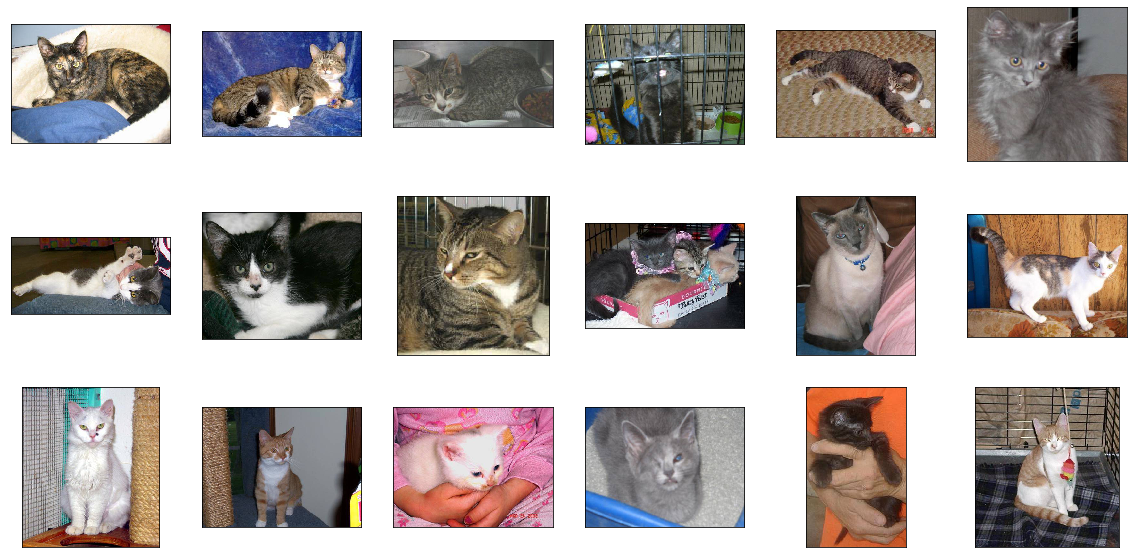

In [8]:
fig, axes = plt.subplots(3, 6, figsize=(20, 10))
names = [i.name for i in (data_path/'train'/'cat').iterdir()]
print(len(names))

for i, ax in enumerate(axes.flat):
    im_name = names[i]
    im = plt.imread(str(data_path/'train/cat'/im_name))
    show_img(im, ax=ax)   

1000


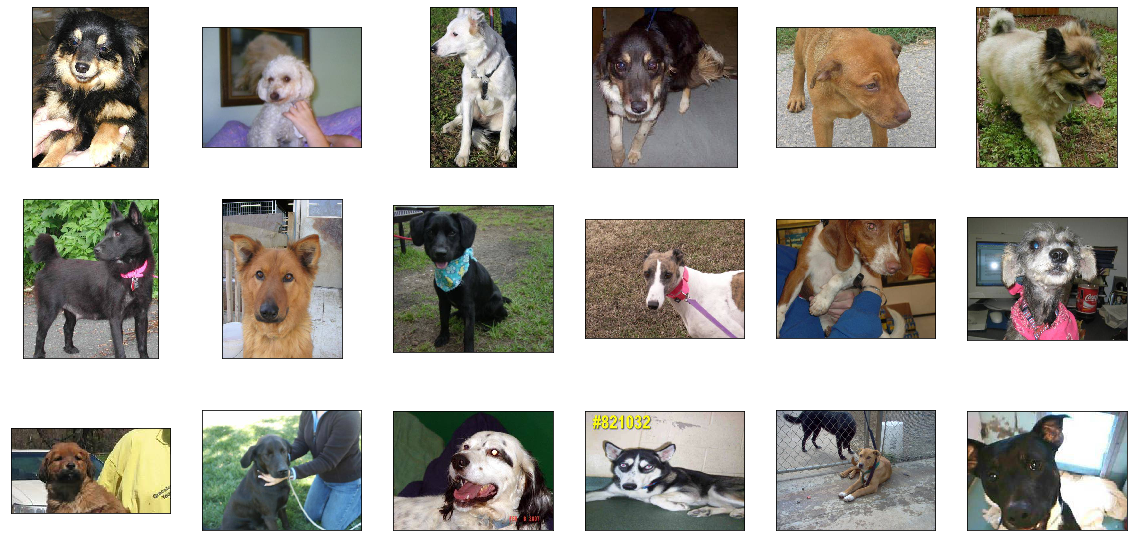

In [9]:
fig, axes = plt.subplots(3, 6, figsize=(20, 10))
names = [i.name for i in (data_path/'train'/'dog').iterdir()]
print(len(names))

for i, ax in enumerate(axes.flat):
    im_name = names[i]
    im = plt.imread(str(data_path/'train/dog'/im_name))
    show_img(im, ax=ax)  

# Handling data

In [10]:
class Vocab:
    
    def __init__(self, items):
        self.vocab = items
        self.item2int = {item:i for i, item in enumerate(items)}
        self.int2item = {i:item for item, i in self.item2int.items()}
        
    def __len__(self):
        return len(self.vocab)

In [11]:
vocab = Vocab([i.name for i in (data_path/'train').iterdir()])

In [12]:
vocab.vocab

['dog', 'cat']

In [13]:
class CatDogDataset(Dataset):
    
    def __init__(self, path, vocab, augs, im_size=(256, 256)):
        self.path = path
        self.vocab = vocab
        self.augs = augs
        self.im_size = im_size
        
        self.cat_imgs = [i.name for i in (path/'cat').iterdir()]
        self.dog_imgs = [i.name for i in (path/'dog').iterdir()]
        self.img_names = self.cat_imgs + self.dog_imgs
        self.labels = [self.vocab.item2int['cat']] * len(self.cat_imgs) + \
                      [self.vocab.item2int['dog']] * len(self.dog_imgs)
        
    def __len__(self):
        return len(self.img_names)
        
    def __getitem__(self, index):
        lbl = self.labels[index]
        
        img_name = self.img_names[index]
        img = plt.imread(str(self.path/self.vocab.int2item[lbl]/img_name)) / 255
        img = cv2.resize(img, self.im_size)
        
        if self.augs:
            img = self.augs(image=img)['image']
            
        img = torch.FloatTensor(img).permute(2,0,1)
        lbl = torch.tensor(lbl).float()
        
        return img, lbl       

# Training procedures

In [14]:
def accuracy(pred, target):
    pred = pred >= 0.5
    target = target >= 0.5
    acc = (pred == target).sum() / torch.tensor(target.numel()).float()
    return acc

In [15]:
def train(model, loader, optimizer, criterion, epoch=None):
    model.train()
    
    if epoch: tqdm_text = f'Training {epoch} epoch'
    else:  tqdm_text = f'Training'
        
    epoch_loss, epoch_acc = 0., 0.
    for i, (imgs, lbls) in tqdm(enumerate(loader), desc=tqdm_text, total=len(loader)):
        
        imgs, lbls = imgs.cuda(), lbls.cuda()
        
        pred = model(imgs).squeeze()
        loss = criterion(pred, lbls)
        acc = accuracy(pred, lbls)
        
        loss.backward()
        
        optimizer.step()
        optimizer.zero_grad()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(loader), epoch_acc / len(loader)


def evaluate(model, loader, criterion, epoch=None):
    model.eval()
    
    if epoch: tqdm_text = f'Evaluating {epoch} epoch'
    else:  tqdm_text = f'Evaluating'
    
    epoch_loss, epoch_acc = 0., 0.
    with torch.no_grad():
        for i, (imgs, lbls) in tqdm(enumerate(loader), desc=tqdm_text, total=len(loader)):

            imgs, lbls = imgs.cuda(), lbls.cuda()

            pred = model(imgs).squeeze()
            loss = criterion(pred, lbls)
            acc = accuracy(pred, lbls)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(loader), epoch_acc / len(loader)


class History():
    
    def __init__(self):
        
        self.train_losses = []
        self.train_accs = []
        self.val_losses = []
        self.val_accs = []
        
    def update(self, train_loss, train_acc, val_loss, val_acc):
        self.train_losses.append(train_loss)
        self.train_accs.append(train_acc)
        self.val_losses.append(val_loss)
        self.val_accs.append(val_acc)
        
    def plot_loss(self, start_epoch=5):
        epochs = list(range(len(history.train_losses)))
        plt.plot(epochs[start_epoch:], history.train_losses[start_epoch:], 'b', label='Train loss')
        plt.plot(epochs[start_epoch:], history.val_losses[start_epoch:], 'r', label='Val loss')
        plt.legend()
        plt.show()
        
    def plot_acc(self, start_epoch=5):
        epochs = list(range(len(history.train_accs)))
        plt.plot(epochs[start_epoch:], history.train_accs[start_epoch:], 'b', label='Train accuracy')
        plt.plot(epochs[start_epoch:], history.val_accs[start_epoch:], 'r', label='Val accuracy')
        plt.legend()
        plt.show()

# Modeling

## Level 1 - knew about computer vision yesterday 🙃

In [16]:
class SimpleModel(nn.Module):
    
    def __init__(self, drop_rate=0.5):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.dropout = nn.Dropout(drop_rate)
        self.fc1 = nn.Linear(in_features=64, out_features=1)
        
    def forward(self, inputs):
        x = torch.relu(self.conv1(inputs))
        x = self.pool(x)
        
        x = torch.relu(self.conv2(x))
        x = self.pool(x)
        
        x = torch.relu(self.conv3(x))
        x = self.pool(x)
        
        x = self.max_pool(x).squeeze()
        x = self.dropout(x)
        
        x = torch.sigmoid(self.fc1(x))
        
        return x

In [17]:
train_ds = CatDogDataset(data_path/'train', vocab, None)
val_ds = CatDogDataset(data_path/'validation', vocab, None)

train_dl = DataLoader(train_ds, 64, shuffle=True)
val_dl = DataLoader(val_ds, 64)

In [18]:
model = SimpleModel()
model.cuda()
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.BCELoss()

In [19]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=5, verbose=True)
history = History()

In [20]:
best_loss = np.inf
for epoch in range(60):
    
    train_loss, train_acc = train(model, train_dl, optimizer, criterion, epoch=epoch+1)
    val_loss, val_acc = evaluate(model, val_dl, criterion, epoch=epoch+1)
    
    if val_loss < best_loss:
        best_loss = val_loss
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_loss': best_loss
        }, base_path/'simple_model.ptr')
        
    scheduler.step(val_loss)
    
    history.update(train_loss, train_acc, val_loss, val_acc)
    
    text = '{} train loss {:.4f}, acc {:.4f}; val loss {:.4f}, acc {:.4f}'
    print(text.format(epoch+1, train_loss, train_acc, val_loss, val_acc))

Training 2 epoch:   0%|          | 0/32 [00:00<?, ?it/s]

1 train loss 0.6943, acc 0.4951; val loss 0.6926, acc 0.5117


Training 3 epoch:   0%|          | 0/32 [00:00<?, ?it/s]

2 train loss 0.6948, acc 0.4927; val loss 0.6910, acc 0.5535


Training 4 epoch:   0%|          | 0/32 [00:00<?, ?it/s]

3 train loss 0.6897, acc 0.5386; val loss 0.6904, acc 0.5117


Training 5 epoch:   0%|          | 0/32 [00:00<?, ?it/s]

4 train loss 0.6872, acc 0.5386; val loss 0.6828, acc 0.5633


Training 6 epoch:   0%|          | 0/32 [00:00<?, ?it/s]

5 train loss 0.6798, acc 0.5835; val loss 0.6829, acc 0.5365


Training 7 epoch:   0%|          | 0/32 [00:00<?, ?it/s]

6 train loss 0.6724, acc 0.5854; val loss 0.6937, acc 0.5293


Training 8 epoch:   0%|          | 0/32 [00:00<?, ?it/s]

7 train loss 0.6762, acc 0.5688; val loss 0.6664, acc 0.5971


Training 9 epoch:   0%|          | 0/32 [00:00<?, ?it/s]

8 train loss 0.6673, acc 0.5938; val loss 0.6709, acc 0.5805


Training 10 epoch:   0%|          | 0/32 [00:00<?, ?it/s]

9 train loss 0.6576, acc 0.6113; val loss 0.6499, acc 0.6531


Training 11 epoch:   0%|          | 0/32 [00:00<?, ?it/s]

10 train loss 0.6557, acc 0.6143; val loss 0.6439, acc 0.6512


Training 12 epoch:   0%|          | 0/32 [00:00<?, ?it/s]

11 train loss 0.6387, acc 0.6514; val loss 0.6310, acc 0.6668


Training 13 epoch:   0%|          | 0/32 [00:00<?, ?it/s]

12 train loss 0.6241, acc 0.6626; val loss 0.6165, acc 0.6816


Training 14 epoch:   0%|          | 0/32 [00:00<?, ?it/s]

13 train loss 0.6223, acc 0.6616; val loss 0.6049, acc 0.6965


Training 15 epoch:   0%|          | 0/32 [00:00<?, ?it/s]

14 train loss 0.6078, acc 0.6709; val loss 0.5938, acc 0.7063


Training 16 epoch:   0%|          | 0/32 [00:00<?, ?it/s]

15 train loss 0.6030, acc 0.6743; val loss 0.6070, acc 0.6775


Training 17 epoch:   0%|          | 0/32 [00:00<?, ?it/s]

16 train loss 0.6011, acc 0.6772; val loss 0.5965, acc 0.7027


Training 18 epoch:   0%|          | 0/32 [00:00<?, ?it/s]

17 train loss 0.5870, acc 0.6953; val loss 0.5867, acc 0.6898


Training 19 epoch:   0%|          | 0/32 [00:00<?, ?it/s]

18 train loss 0.5916, acc 0.6895; val loss 0.5929, acc 0.6793


Training 20 epoch:   0%|          | 0/32 [00:00<?, ?it/s]

19 train loss 0.5687, acc 0.7061; val loss 0.5786, acc 0.7039


Training 21 epoch:   0%|          | 0/32 [00:00<?, ?it/s]

20 train loss 0.5831, acc 0.6943; val loss 0.6071, acc 0.6381


Training 22 epoch:   0%|          | 0/32 [00:00<?, ?it/s]

21 train loss 0.5743, acc 0.7095; val loss 0.5655, acc 0.7184


Training 23 epoch:   0%|          | 0/32 [00:00<?, ?it/s]

22 train loss 0.5675, acc 0.7129; val loss 0.5622, acc 0.7256


Training 24 epoch:   0%|          | 0/32 [00:00<?, ?it/s]

23 train loss 0.5530, acc 0.7119; val loss 0.5586, acc 0.7268


Training 25 epoch:   0%|          | 0/32 [00:00<?, ?it/s]

24 train loss 0.5485, acc 0.7246; val loss 0.5634, acc 0.7225


Training 26 epoch:   0%|          | 0/32 [00:00<?, ?it/s]

25 train loss 0.5467, acc 0.7295; val loss 0.5562, acc 0.7219


Training 27 epoch:   0%|          | 0/32 [00:00<?, ?it/s]

26 train loss 0.5551, acc 0.7134; val loss 0.5615, acc 0.7219


Training 28 epoch:   0%|          | 0/32 [00:00<?, ?it/s]

27 train loss 0.5269, acc 0.7456; val loss 0.5580, acc 0.7035


Training 29 epoch:   0%|          | 0/32 [00:00<?, ?it/s]

28 train loss 0.5349, acc 0.7388; val loss 0.5408, acc 0.7439


Training 30 epoch:   0%|          | 0/32 [00:00<?, ?it/s]

29 train loss 0.5195, acc 0.7412; val loss 0.5480, acc 0.7318


Training 31 epoch:   0%|          | 0/32 [00:00<?, ?it/s]

30 train loss 0.5190, acc 0.7495; val loss 0.5424, acc 0.7316


Training 32 epoch:   0%|          | 0/32 [00:00<?, ?it/s]

31 train loss 0.5180, acc 0.7603; val loss 0.5364, acc 0.7307


Training 33 epoch:   0%|          | 0/32 [00:00<?, ?it/s]

32 train loss 0.5039, acc 0.7598; val loss 0.5436, acc 0.7328


Training 34 epoch:   0%|          | 0/32 [00:00<?, ?it/s]

33 train loss 0.5157, acc 0.7480; val loss 0.5386, acc 0.7348


Training 35 epoch:   0%|          | 0/32 [00:00<?, ?it/s]

34 train loss 0.4997, acc 0.7666; val loss 0.5302, acc 0.7451


Training 36 epoch:   0%|          | 0/32 [00:00<?, ?it/s]

35 train loss 0.5032, acc 0.7637; val loss 0.5327, acc 0.7338


Training 37 epoch:   0%|          | 0/32 [00:00<?, ?it/s]

36 train loss 0.4865, acc 0.7695; val loss 0.5477, acc 0.7350


Training 38 epoch:   0%|          | 0/32 [00:00<?, ?it/s]

37 train loss 0.4885, acc 0.7656; val loss 0.5240, acc 0.7434


Training 39 epoch:   0%|          | 0/32 [00:00<?, ?it/s]

38 train loss 0.4887, acc 0.7725; val loss 0.5527, acc 0.7268


Training 40 epoch:   0%|          | 0/32 [00:00<?, ?it/s]

39 train loss 0.4658, acc 0.7837; val loss 0.5286, acc 0.7428


Training 41 epoch:   0%|          | 0/32 [00:00<?, ?it/s]

40 train loss 0.4842, acc 0.7773; val loss 0.5209, acc 0.7477


Training 42 epoch:   0%|          | 0/32 [00:00<?, ?it/s]

41 train loss 0.4637, acc 0.7808; val loss 0.5312, acc 0.7398


Training 43 epoch:   0%|          | 0/32 [00:00<?, ?it/s]

42 train loss 0.4567, acc 0.7876; val loss 0.5106, acc 0.7531


Training 44 epoch:   0%|          | 0/32 [00:00<?, ?it/s]

43 train loss 0.4769, acc 0.7861; val loss 0.5225, acc 0.7543


Training 45 epoch:   0%|          | 0/32 [00:00<?, ?it/s]

44 train loss 0.4673, acc 0.7871; val loss 0.5233, acc 0.7449


Training 46 epoch:   0%|          | 0/32 [00:00<?, ?it/s]

45 train loss 0.4513, acc 0.8013; val loss 0.5400, acc 0.7299


Training 47 epoch:   0%|          | 0/32 [00:00<?, ?it/s]

46 train loss 0.4587, acc 0.7803; val loss 0.5223, acc 0.7465


Training 48 epoch:   0%|          | 0/32 [00:00<?, ?it/s]

47 train loss 0.4435, acc 0.8042; val loss 0.5111, acc 0.7576


Training 49 epoch:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch    47: reducing learning rate of group 0 to 5.0000e-04.
48 train loss 0.4363, acc 0.8052; val loss 0.5185, acc 0.7531


Training 50 epoch:   0%|          | 0/32 [00:00<?, ?it/s]

49 train loss 0.4330, acc 0.8110; val loss 0.5113, acc 0.7537


Training 51 epoch:   0%|          | 0/32 [00:00<?, ?it/s]

50 train loss 0.4096, acc 0.8208; val loss 0.5113, acc 0.7559


Training 52 epoch:   0%|          | 0/32 [00:00<?, ?it/s]

51 train loss 0.4356, acc 0.7983; val loss 0.5076, acc 0.7607


Training 53 epoch:   0%|          | 0/32 [00:00<?, ?it/s]

52 train loss 0.4163, acc 0.8149; val loss 0.5091, acc 0.7520


Training 54 epoch:   0%|          | 0/32 [00:00<?, ?it/s]

53 train loss 0.4293, acc 0.8179; val loss 0.5091, acc 0.7564


Training 55 epoch:   0%|          | 0/32 [00:00<?, ?it/s]

54 train loss 0.4146, acc 0.8130; val loss 0.5081, acc 0.7555


Training 56 epoch:   0%|          | 0/32 [00:00<?, ?it/s]

55 train loss 0.4164, acc 0.8164; val loss 0.5250, acc 0.7438


Training 57 epoch:   0%|          | 0/32 [00:00<?, ?it/s]

56 train loss 0.4022, acc 0.8291; val loss 0.5062, acc 0.7561


Training 58 epoch:   0%|          | 0/32 [00:00<?, ?it/s]

57 train loss 0.4142, acc 0.8149; val loss 0.5188, acc 0.7459


Training 59 epoch:   0%|          | 0/32 [00:00<?, ?it/s]

58 train loss 0.4138, acc 0.8179; val loss 0.5264, acc 0.7416


Training 60 epoch:   0%|          | 0/32 [00:00<?, ?it/s]

59 train loss 0.4193, acc 0.8105; val loss 0.5072, acc 0.7541


Evaluating 60 epoch: 100%|██████████| 16/16 [00:02<00:00,  5.40it/s]

60 train loss 0.4144, acc 0.8105; val loss 0.5383, acc 0.7313


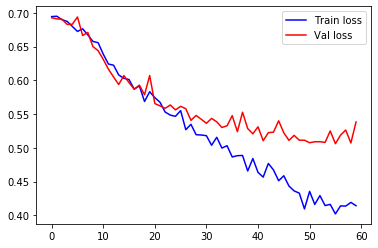

In [21]:
history.plot_loss(0)

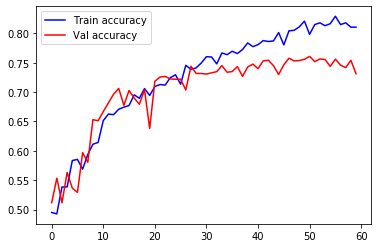

In [22]:
history.plot_acc(0)

## Augmentations are important

In [23]:
train_augs = Compose([
    HorizontalFlip(),
    RandomBrightnessContrast(),
    ShiftScaleRotate(),
    Cutout(1, 50, 50),
])

In [24]:
train_ds = CatDogDataset(data_path/'train', vocab, train_augs)
val_ds = CatDogDataset(data_path/'validation', vocab, None)

train_dl = DataLoader(train_ds, 64, shuffle=True)
val_dl = DataLoader(val_ds, 64)

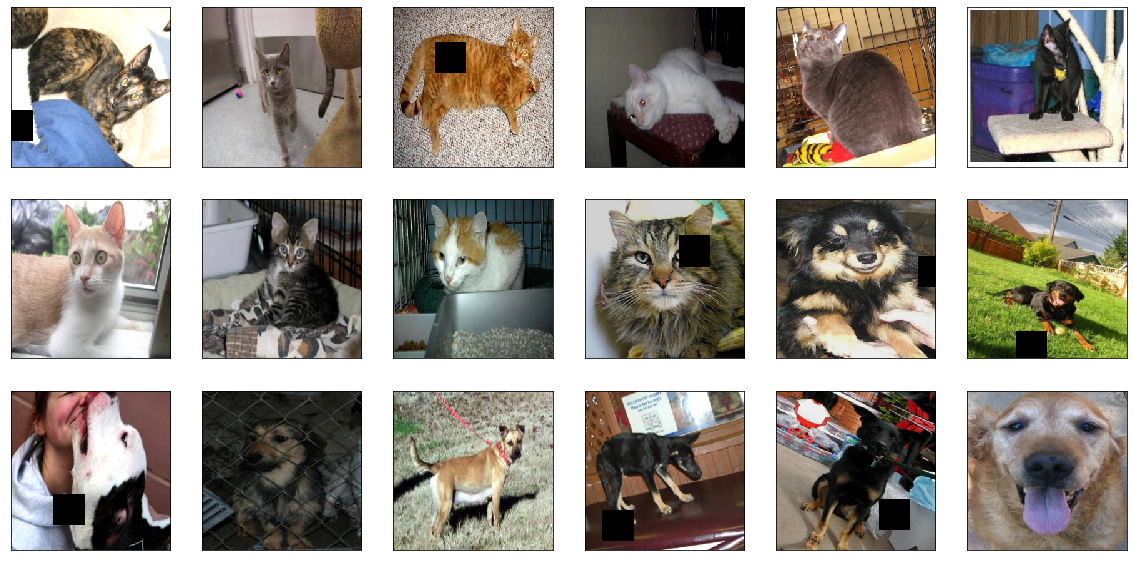

In [25]:
fig, axes = plt.subplots(3, 6, figsize=(20, 10))

for i, ax in enumerate(axes.flat):
    im, _ = train_ds[i * 100]
    im = tensorimg2np(im)
    show_img(im, ax=ax)   

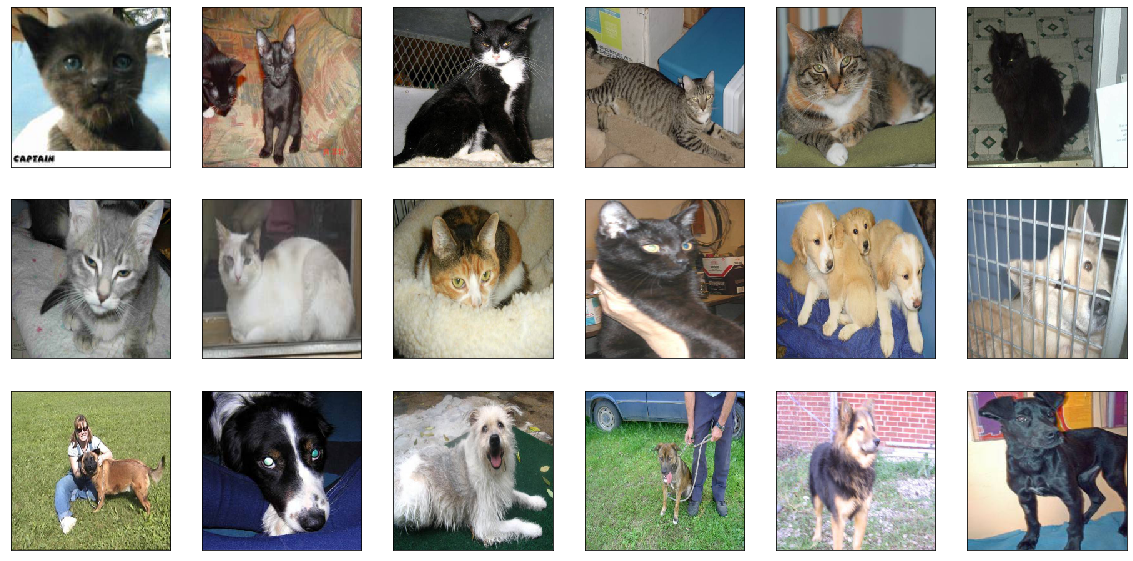

In [26]:
fig, axes = plt.subplots(3, 6, figsize=(20, 10))

for i, ax in enumerate(axes.flat):
    im, _ = val_ds[i * 50]
    im = tensorimg2np(im)
    show_img(im, ax=ax) 

In [27]:
model = SimpleModel()
model.cuda()
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.BCELoss()

In [28]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=5, verbose=True)
history = History()

In [29]:
best_loss = np.inf
for epoch in range(60):
    
    train_loss, train_acc = train(model, train_dl, optimizer, criterion, epoch=epoch+1)
    val_loss, val_acc = evaluate(model, val_dl, criterion, epoch=epoch+1)
    
    if val_loss < best_loss:
        best_loss = val_loss
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_loss': best_loss
        }, base_path/'simple_model+augs.ptr')
        
    scheduler.step(val_loss)
    
    history.update(train_loss, train_acc, val_loss, val_acc)
    
    text = '{} train loss {:.4f}, acc {:.4f}; val loss {:.4f}, acc {:.4f}'
    print(text.format(epoch+1, train_loss, train_acc, val_loss, val_acc))

Training 2 epoch:   0%|          | 0/32 [00:00<?, ?it/s]

1 train loss 0.6937, acc 0.5020; val loss 0.6926, acc 0.5117


Training 3 epoch:   0%|          | 0/32 [00:00<?, ?it/s]

2 train loss 0.6932, acc 0.5015; val loss 0.6919, acc 0.5176


Training 4 epoch:   0%|          | 0/32 [00:00<?, ?it/s]

3 train loss 0.6926, acc 0.5122; val loss 0.6911, acc 0.5229


Training 5 epoch:   0%|          | 0/32 [00:00<?, ?it/s]

4 train loss 0.6919, acc 0.5190; val loss 0.6884, acc 0.5762


Training 6 epoch:   0%|          | 0/32 [00:00<?, ?it/s]

5 train loss 0.6892, acc 0.5366; val loss 0.6827, acc 0.5715


Training 7 epoch:   0%|          | 0/32 [00:00<?, ?it/s]

6 train loss 0.6878, acc 0.5259; val loss 0.6847, acc 0.5494


Training 8 epoch:   0%|          | 0/32 [00:00<?, ?it/s]

7 train loss 0.6842, acc 0.5425; val loss 0.6708, acc 0.6238


Training 9 epoch:   0%|          | 0/32 [00:00<?, ?it/s]

8 train loss 0.6729, acc 0.5859; val loss 0.6565, acc 0.6375


Training 10 epoch:   0%|          | 0/32 [00:00<?, ?it/s]

9 train loss 0.6558, acc 0.6108; val loss 0.6452, acc 0.6098


Training 11 epoch:   0%|          | 0/32 [00:00<?, ?it/s]

10 train loss 0.6546, acc 0.6074; val loss 0.6399, acc 0.6344


Training 12 epoch:   0%|          | 0/32 [00:00<?, ?it/s]

11 train loss 0.6454, acc 0.6172; val loss 0.6392, acc 0.6186


Training 13 epoch:   0%|          | 0/32 [00:00<?, ?it/s]

12 train loss 0.6529, acc 0.6128; val loss 0.6337, acc 0.6455


Training 14 epoch:   0%|          | 0/32 [00:00<?, ?it/s]

13 train loss 0.6359, acc 0.6235; val loss 0.6249, acc 0.6250


Training 15 epoch:   0%|          | 0/32 [00:00<?, ?it/s]

14 train loss 0.6363, acc 0.6377; val loss 0.6299, acc 0.6475


Training 16 epoch:   0%|          | 0/32 [00:00<?, ?it/s]

15 train loss 0.6331, acc 0.6528; val loss 0.6213, acc 0.6545


Training 17 epoch:   0%|          | 0/32 [00:00<?, ?it/s]

16 train loss 0.6384, acc 0.6421; val loss 0.6311, acc 0.6742


Training 18 epoch:   0%|          | 0/32 [00:00<?, ?it/s]

17 train loss 0.6313, acc 0.6479; val loss 0.6173, acc 0.6646


Training 19 epoch:   0%|          | 0/32 [00:00<?, ?it/s]

18 train loss 0.6317, acc 0.6343; val loss 0.6150, acc 0.6568


Training 20 epoch:   0%|          | 0/32 [00:00<?, ?it/s]

19 train loss 0.6280, acc 0.6514; val loss 0.6168, acc 0.6580


Training 21 epoch:   0%|          | 0/32 [00:00<?, ?it/s]

20 train loss 0.6268, acc 0.6372; val loss 0.6167, acc 0.6527


Training 22 epoch:   0%|          | 0/32 [00:00<?, ?it/s]

21 train loss 0.6138, acc 0.6562; val loss 0.6188, acc 0.6381


Training 23 epoch:   0%|          | 0/32 [00:00<?, ?it/s]

22 train loss 0.6227, acc 0.6567; val loss 0.6124, acc 0.6723


Training 24 epoch:   0%|          | 0/32 [00:00<?, ?it/s]

23 train loss 0.6084, acc 0.6758; val loss 0.6044, acc 0.6645


Training 25 epoch:   0%|          | 0/32 [00:00<?, ?it/s]

24 train loss 0.6122, acc 0.6528; val loss 0.6037, acc 0.6645


Training 26 epoch:   0%|          | 0/32 [00:00<?, ?it/s]

25 train loss 0.6202, acc 0.6528; val loss 0.6023, acc 0.6719


Training 27 epoch:   0%|          | 0/32 [00:00<?, ?it/s]

26 train loss 0.6013, acc 0.6650; val loss 0.5978, acc 0.6777


Training 28 epoch:   0%|          | 0/32 [00:00<?, ?it/s]

27 train loss 0.6109, acc 0.6631; val loss 0.5933, acc 0.6732


Training 29 epoch:   0%|          | 0/32 [00:00<?, ?it/s]

28 train loss 0.6081, acc 0.6655; val loss 0.5987, acc 0.6793


Training 30 epoch:   0%|          | 0/32 [00:00<?, ?it/s]

29 train loss 0.6067, acc 0.6655; val loss 0.5997, acc 0.6916


Training 31 epoch:   0%|          | 0/32 [00:00<?, ?it/s]

30 train loss 0.6095, acc 0.6782; val loss 0.5958, acc 0.6770


Training 32 epoch:   0%|          | 0/32 [00:00<?, ?it/s]

31 train loss 0.5991, acc 0.6743; val loss 0.5935, acc 0.6787


Training 33 epoch:   0%|          | 0/32 [00:00<?, ?it/s]

32 train loss 0.5980, acc 0.6758; val loss 0.5867, acc 0.6895


Training 34 epoch:   0%|          | 0/32 [00:00<?, ?it/s]

33 train loss 0.5909, acc 0.6792; val loss 0.5911, acc 0.6852


Training 35 epoch:   0%|          | 0/32 [00:00<?, ?it/s]

34 train loss 0.5934, acc 0.6816; val loss 0.5850, acc 0.6801


Training 36 epoch:   0%|          | 0/32 [00:00<?, ?it/s]

35 train loss 0.6021, acc 0.6646; val loss 0.5874, acc 0.6891


Training 37 epoch:   0%|          | 0/32 [00:00<?, ?it/s]

36 train loss 0.5876, acc 0.6860; val loss 0.5914, acc 0.6686


Training 38 epoch:   0%|          | 0/32 [00:00<?, ?it/s]

37 train loss 0.6037, acc 0.6772; val loss 0.5835, acc 0.6943


Training 39 epoch:   0%|          | 0/32 [00:00<?, ?it/s]

38 train loss 0.5929, acc 0.6924; val loss 0.5975, acc 0.6676


Training 40 epoch:   0%|          | 0/32 [00:00<?, ?it/s]

39 train loss 0.5986, acc 0.6768; val loss 0.5978, acc 0.6713


Training 41 epoch:   0%|          | 0/32 [00:00<?, ?it/s]

40 train loss 0.5839, acc 0.6890; val loss 0.5775, acc 0.6922


Training 42 epoch:   0%|          | 0/32 [00:00<?, ?it/s]

41 train loss 0.5876, acc 0.6870; val loss 0.5765, acc 0.6939


Training 43 epoch:   0%|          | 0/32 [00:00<?, ?it/s]

42 train loss 0.5938, acc 0.6904; val loss 0.5797, acc 0.6973


Training 44 epoch:   0%|          | 0/32 [00:00<?, ?it/s]

43 train loss 0.5829, acc 0.6807; val loss 0.5789, acc 0.6865


Training 45 epoch:   0%|          | 0/32 [00:00<?, ?it/s]

44 train loss 0.5859, acc 0.6870; val loss 0.5854, acc 0.6955


Training 46 epoch:   0%|          | 0/32 [00:00<?, ?it/s]

45 train loss 0.5811, acc 0.6855; val loss 0.5743, acc 0.7018


Training 47 epoch:   0%|          | 0/32 [00:00<?, ?it/s]

46 train loss 0.5741, acc 0.6934; val loss 0.5744, acc 0.7029


Training 48 epoch:   0%|          | 0/32 [00:00<?, ?it/s]

47 train loss 0.5716, acc 0.7017; val loss 0.5703, acc 0.6990


Training 49 epoch:   0%|          | 0/32 [00:00<?, ?it/s]

48 train loss 0.5785, acc 0.6938; val loss 0.5842, acc 0.6951


Training 50 epoch:   0%|          | 0/32 [00:00<?, ?it/s]

49 train loss 0.5821, acc 0.7002; val loss 0.5780, acc 0.6670


Training 51 epoch:   0%|          | 0/32 [00:00<?, ?it/s]

50 train loss 0.5734, acc 0.7056; val loss 0.5782, acc 0.6881


Training 52 epoch:   0%|          | 0/32 [00:00<?, ?it/s]

51 train loss 0.5722, acc 0.7051; val loss 0.5637, acc 0.7096


Training 53 epoch:   0%|          | 0/32 [00:00<?, ?it/s]

52 train loss 0.5821, acc 0.6934; val loss 0.5644, acc 0.7070


Training 54 epoch:   0%|          | 0/32 [00:00<?, ?it/s]

53 train loss 0.5624, acc 0.7104; val loss 0.5807, acc 0.6959


Training 55 epoch:   0%|          | 0/32 [00:00<?, ?it/s]

54 train loss 0.5715, acc 0.6953; val loss 0.5979, acc 0.6809


Training 56 epoch:   0%|          | 0/32 [00:00<?, ?it/s]

55 train loss 0.5883, acc 0.6743; val loss 0.5663, acc 0.7158


Training 57 epoch:   0%|          | 0/32 [00:00<?, ?it/s]

56 train loss 0.5628, acc 0.7007; val loss 0.5611, acc 0.7049


Training 58 epoch:   0%|          | 0/32 [00:00<?, ?it/s]

57 train loss 0.5585, acc 0.7134; val loss 0.5641, acc 0.7018


Training 59 epoch:   0%|          | 0/32 [00:00<?, ?it/s]

58 train loss 0.5688, acc 0.7051; val loss 0.5548, acc 0.7207


Training 60 epoch:   0%|          | 0/32 [00:00<?, ?it/s]

59 train loss 0.5497, acc 0.7183; val loss 0.5515, acc 0.7068


Evaluating 60 epoch: 100%|██████████| 16/16 [00:02<00:00,  5.38it/s]

60 train loss 0.5637, acc 0.7100; val loss 0.5578, acc 0.7238


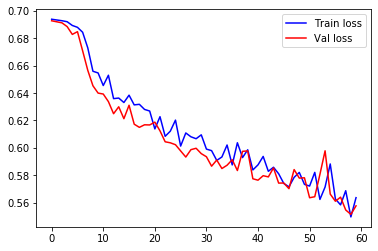

In [30]:
history.plot_loss(0)

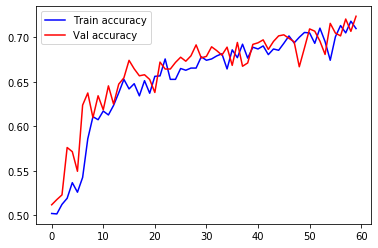

In [31]:
history.plot_acc(0)

## Level 2 - know about vgg, resnet and others

In [18]:
from torchvision.models.resnet import resnet50

class Resnet50(nn.Module):
    
    def __init__(self, hid_dim=512, drop_rate=0.2):
        super().__init__()
        self.backbone = resnet50()
        self.backbone.fc = nn.Sequential(nn.Linear(2048, hid_dim),
                                         nn.ReLU(),
                                         nn.Dropout(drop_rate),
                                         nn.Linear(hid_dim, 1))
        
    def forward(self, inputs):
        out = self.backbone(inputs)
        out = torch.sigmoid(out)
        return out

In [19]:
train_augs = Compose([
    HorizontalFlip(),
    RandomBrightnessContrast(),
    ShiftScaleRotate(),
    Cutout(1, 50, 50),
])

In [20]:
train_ds = CatDogDataset(data_path/'train', vocab, train_augs)
val_ds = CatDogDataset(data_path/'validation', vocab, None)

train_dl = DataLoader(train_ds, 64, shuffle=True)
val_dl = DataLoader(val_ds, 64)

In [21]:
model = Resnet50(drop_rate=0.5)
model.cuda()
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.BCELoss()

In [22]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=5, verbose=True)
history = History()

In [23]:
best_loss = np.inf
for epoch in range(30):
    
    train_loss, train_acc = train(model, train_dl, optimizer, criterion, epoch=epoch+1)
    val_loss, val_acc = evaluate(model, val_dl, criterion, epoch=epoch+1)
    
    if val_loss < best_loss:
        best_loss = val_loss
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_loss': best_loss
        }, base_path/'resnet50_model.ptr')
        
    scheduler.step(val_loss)
    
    history.update(train_loss, train_acc, val_loss, val_acc)
    
    text = '{} train loss {:.4f}, acc {:.4f}; val loss {:.4f}, acc {:.4f}'
    print(text.format(epoch+1, train_loss, train_acc, val_loss, val_acc))

Training 2 epoch:   0%|          | 0/32 [00:00<?, ?it/s]

1 train loss 0.8007, acc 0.5063; val loss 0.6978, acc 0.4883


Training 3 epoch:   0%|          | 0/32 [00:00<?, ?it/s]

2 train loss 0.7452, acc 0.4873; val loss 0.6990, acc 0.4883


Training 4 epoch:   0%|          | 0/32 [00:00<?, ?it/s]

3 train loss 0.6970, acc 0.5430; val loss 0.6889, acc 0.5400


Training 5 epoch:   0%|          | 0/32 [00:00<?, ?it/s]

4 train loss 0.6793, acc 0.5610; val loss 1.0465, acc 0.6207


Training 6 epoch:   0%|          | 0/32 [00:00<?, ?it/s]

5 train loss 0.6661, acc 0.5850; val loss 0.6765, acc 0.5951


Training 7 epoch:   0%|          | 0/32 [00:00<?, ?it/s]

6 train loss 0.6392, acc 0.6294; val loss 0.6501, acc 0.5947


Training 8 epoch:   0%|          | 0/32 [00:00<?, ?it/s]

7 train loss 0.6303, acc 0.6538; val loss 0.8266, acc 0.5654


Training 9 epoch:   0%|          | 0/32 [00:00<?, ?it/s]

8 train loss 0.6441, acc 0.6221; val loss 0.6334, acc 0.6215


Training 10 epoch:   0%|          | 0/32 [00:00<?, ?it/s]

9 train loss 0.6184, acc 0.6733; val loss 0.7504, acc 0.5678


Training 11 epoch:   0%|          | 0/32 [00:00<?, ?it/s]

10 train loss 0.6120, acc 0.6704; val loss 0.6665, acc 0.5861


Training 12 epoch:   0%|          | 0/32 [00:00<?, ?it/s]

11 train loss 0.6161, acc 0.6694; val loss 0.6398, acc 0.6273


Training 13 epoch:   0%|          | 0/32 [00:00<?, ?it/s]

12 train loss 0.5944, acc 0.6875; val loss 0.6524, acc 0.6049


Training 14 epoch:   0%|          | 0/32 [00:00<?, ?it/s]

13 train loss 0.5911, acc 0.6885; val loss 0.7008, acc 0.5824


Training 15 epoch:   0%|          | 0/32 [00:00<?, ?it/s]

14 train loss 0.6074, acc 0.6914; val loss 0.6331, acc 0.6705


Training 16 epoch:   0%|          | 0/32 [00:00<?, ?it/s]

15 train loss 0.5976, acc 0.6919; val loss 0.7068, acc 0.5799


Training 17 epoch:   0%|          | 0/32 [00:00<?, ?it/s]

16 train loss 0.5979, acc 0.6978; val loss 0.7034, acc 0.5996


Training 18 epoch:   0%|          | 0/32 [00:00<?, ?it/s]

17 train loss 0.5942, acc 0.6855; val loss 0.5962, acc 0.6859


Training 19 epoch:   0%|          | 0/32 [00:00<?, ?it/s]

18 train loss 0.5808, acc 0.7026; val loss 0.5820, acc 0.6879


Training 20 epoch:   0%|          | 0/32 [00:00<?, ?it/s]

19 train loss 0.5717, acc 0.7109; val loss 0.6003, acc 0.6779


Training 21 epoch:   0%|          | 0/32 [00:00<?, ?it/s]

20 train loss 0.5501, acc 0.7256; val loss 0.6080, acc 0.6848


Training 22 epoch:   0%|          | 0/32 [00:00<?, ?it/s]

21 train loss 0.5704, acc 0.7222; val loss 0.7157, acc 0.6332


Training 23 epoch:   0%|          | 0/32 [00:00<?, ?it/s]

22 train loss 0.5503, acc 0.7266; val loss 0.5829, acc 0.6754


Training 24 epoch:   0%|          | 0/32 [00:00<?, ?it/s]

23 train loss 0.5529, acc 0.7153; val loss 0.5922, acc 0.6973


Training 25 epoch:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch    23: reducing learning rate of group 0 to 5.0000e-04.
24 train loss 0.5485, acc 0.7378; val loss 0.6742, acc 0.6395


Training 26 epoch:   0%|          | 0/32 [00:00<?, ?it/s]

25 train loss 0.5417, acc 0.7378; val loss 0.5446, acc 0.7213


Training 27 epoch:   0%|          | 0/32 [00:00<?, ?it/s]

26 train loss 0.5118, acc 0.7549; val loss 0.5350, acc 0.7240


Training 28 epoch:   0%|          | 0/32 [00:00<?, ?it/s]

27 train loss 0.5156, acc 0.7456; val loss 0.5393, acc 0.7168


Training 29 epoch:   0%|          | 0/32 [00:00<?, ?it/s]

28 train loss 0.4933, acc 0.7671; val loss 0.5438, acc 0.7209


Training 30 epoch:   0%|          | 0/32 [00:00<?, ?it/s]

29 train loss 0.5115, acc 0.7588; val loss 0.5110, acc 0.7574


Evaluating 30 epoch: 100%|██████████| 16/16 [00:05<00:00,  2.84it/s]

30 train loss 0.4953, acc 0.7720; val loss 0.5228, acc 0.7387


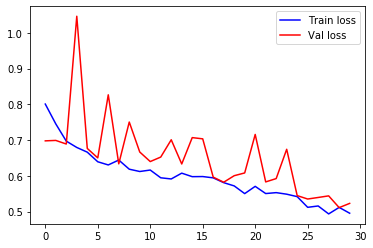

In [24]:
history.plot_loss(0)

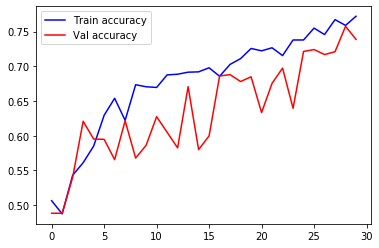

In [25]:
history.plot_acc(0)

## Level 3 - Transfer learning

In [16]:
from torchvision.models.resnet import resnet50

class Resnet50(nn.Module):
    
    def __init__(self, hid_dim=512, drop_rate=0.2):
        super().__init__()
        self.backbone = resnet50(pretrained=True)
        self.backbone.fc = nn.Sequential(nn.Linear(2048, hid_dim),
                                         nn.ReLU(),
                                         nn.Dropout(drop_rate),
                                         nn.Linear(hid_dim, 1))
        
    def forward(self, inputs):
        out = self.backbone(inputs)
        return out

In [17]:
train_augs = Compose([
    HorizontalFlip(),
    RandomBrightnessContrast(),
    ShiftScaleRotate(),
    Cutout(2, 50, 50),
    Normalize(max_pixel_value=1)
])

val_augs = Compose([
    Normalize(max_pixel_value=1)
])

In [18]:
train_ds = CatDogDataset(data_path/'train', vocab, train_augs)
val_ds = CatDogDataset(data_path/'validation', vocab, val_augs)

train_dl = DataLoader(train_ds, 64, shuffle=True)
val_dl = DataLoader(val_ds, 64)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

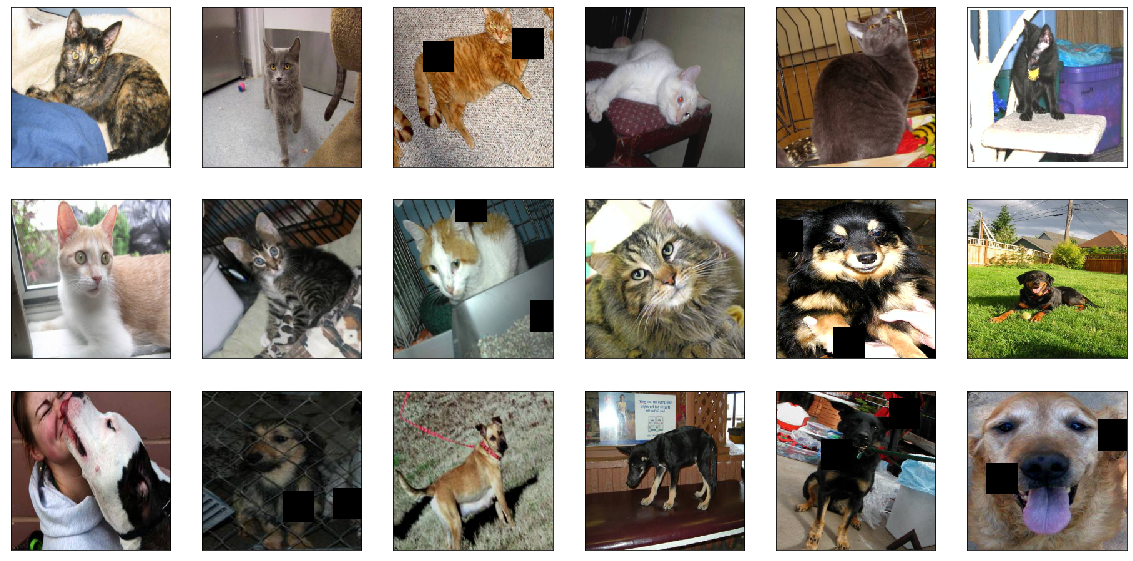

In [19]:
fig, axes = plt.subplots(3, 6, figsize=(20, 10))

for i, ax in enumerate(axes.flat):
    im, _ = train_ds[i * 100]
    im = denorm(tensorimg2np(im))
    show_img(im, ax=ax)   

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

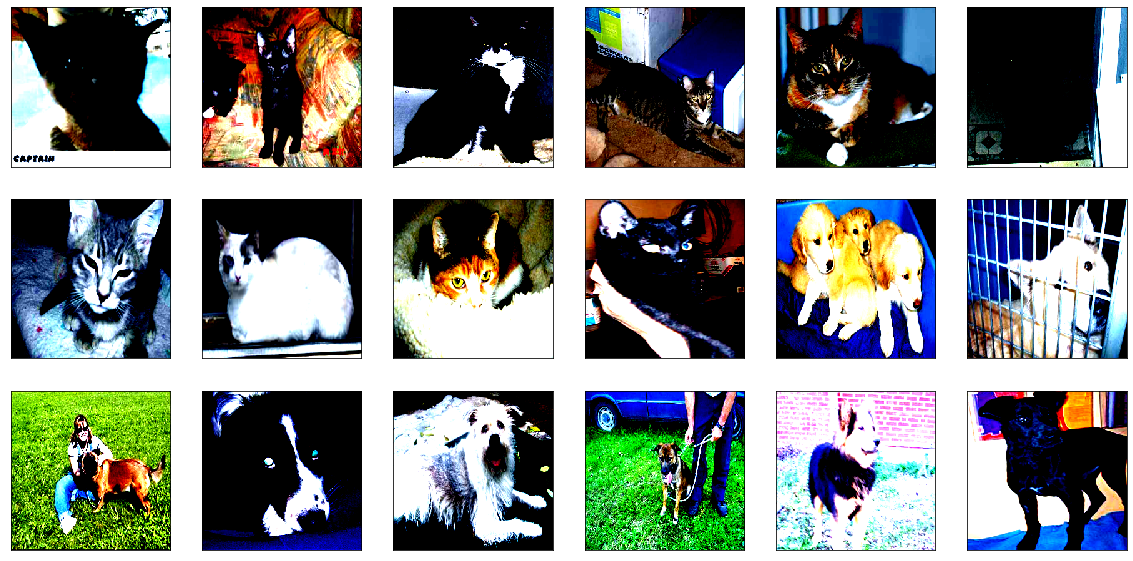

In [20]:
fig, axes = plt.subplots(3, 6, figsize=(20, 10))

for i, ax in enumerate(axes.flat):
    im, _ = val_ds[i * 50]
    im = tensorimg2np(im)
    show_img(im, ax=ax) 

In [21]:
model = Resnet50(drop_rate=0.5)
model.cuda();

In [22]:
for name, param in model.named_parameters():
    param.requires_grad = False if 'fc' not in name else True
        
print([(name, param.requires_grad) for name, param in model.named_parameters()])

[('backbone.conv1.weight', False), ('backbone.bn1.weight', False), ('backbone.bn1.bias', False), ('backbone.layer1.0.conv1.weight', False), ('backbone.layer1.0.bn1.weight', False), ('backbone.layer1.0.bn1.bias', False), ('backbone.layer1.0.conv2.weight', False), ('backbone.layer1.0.bn2.weight', False), ('backbone.layer1.0.bn2.bias', False), ('backbone.layer1.0.conv3.weight', False), ('backbone.layer1.0.bn3.weight', False), ('backbone.layer1.0.bn3.bias', False), ('backbone.layer1.0.downsample.0.weight', False), ('backbone.layer1.0.downsample.1.weight', False), ('backbone.layer1.0.downsample.1.bias', False), ('backbone.layer1.1.conv1.weight', False), ('backbone.layer1.1.bn1.weight', False), ('backbone.layer1.1.bn1.bias', False), ('backbone.layer1.1.conv2.weight', False), ('backbone.layer1.1.bn2.weight', False), ('backbone.layer1.1.bn2.bias', False), ('backbone.layer1.1.conv3.weight', False), ('backbone.layer1.1.bn3.weight', False), ('backbone.layer1.1.bn3.bias', False), ('backbone.layer1

In [23]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.BCEWithLogitsLoss()

In [24]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=5, verbose=True)
history = History()

In [25]:
train_loss, train_acc = train(model, train_dl, optimizer, criterion)
val_loss, val_acc = evaluate(model, val_dl, criterion)
    
text = 'train loss {:.4f}, acc {:.4f}; val loss {:.4f}, acc {:.4f}'
print(text.format(train_loss, train_acc, val_loss, val_acc))

Evaluating: 100%|██████████| 16/16 [00:06<00:00,  2.63it/s]

train loss 0.2895, acc 0.8647; val loss 0.0520, acc 0.9805


In [26]:
for param in model.parameters():
    param.requires_grad = True

In [27]:
for group in optimizer.param_groups:
    group['lr'] = 3e-5

In [28]:
best_loss = np.inf
for epoch in range(10):
    
    train_loss, train_acc = train(model, train_dl, optimizer, criterion, epoch=epoch+1)
    val_loss, val_acc = evaluate(model, val_dl, criterion, epoch=epoch+1)
    
    if val_loss < best_loss:
        best_loss = val_loss
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_loss': best_loss
        }, base_path/'resnet50_model_pretrained.ptr')
        
    scheduler.step(val_loss)
    
    history.update(train_loss, train_acc, val_loss, val_acc)
    
    text = '{} train loss {:.4f}, acc {:.4f}; val loss {:.4f}, acc {:.4f}'
    print(text.format(epoch+1, train_loss, train_acc, val_loss, val_acc))

Training 2 epoch:   0%|          | 0/32 [00:00<?, ?it/s]

1 train loss 0.0700, acc 0.9731; val loss 0.0192, acc 0.9932


Training 3 epoch:   0%|          | 0/32 [00:00<?, ?it/s]

2 train loss 0.0333, acc 0.9883; val loss 0.0135, acc 0.9961


Training 4 epoch:   0%|          | 0/32 [00:00<?, ?it/s]

3 train loss 0.0341, acc 0.9888; val loss 0.0270, acc 0.9824


Training 5 epoch:   0%|          | 0/32 [00:00<?, ?it/s]

4 train loss 0.0306, acc 0.9873; val loss 0.0116, acc 0.9971


Training 6 epoch:   0%|          | 0/32 [00:00<?, ?it/s]

5 train loss 0.0175, acc 0.9917; val loss 0.0148, acc 0.9941


Training 7 epoch:   0%|          | 0/32 [00:00<?, ?it/s]

6 train loss 0.0246, acc 0.9917; val loss 0.0133, acc 0.9971


Training 8 epoch:   0%|          | 0/32 [00:00<?, ?it/s]

7 train loss 0.0131, acc 0.9961; val loss 0.0156, acc 0.9941


Training 9 epoch:   0%|          | 0/32 [00:00<?, ?it/s]

8 train loss 0.0114, acc 0.9951; val loss 0.0109, acc 0.9971


Training 10 epoch:   0%|          | 0/32 [00:00<?, ?it/s]

9 train loss 0.0071, acc 0.9971; val loss 0.0108, acc 0.9971


Evaluating 10 epoch: 100%|██████████| 16/16 [00:06<00:00,  2.62it/s]

10 train loss 0.0138, acc 0.9961; val loss 0.0151, acc 0.9932


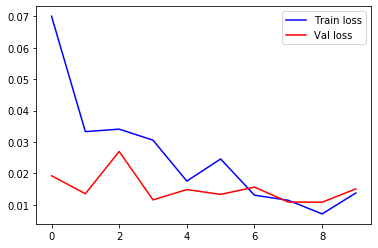

In [29]:
history.plot_loss(0)

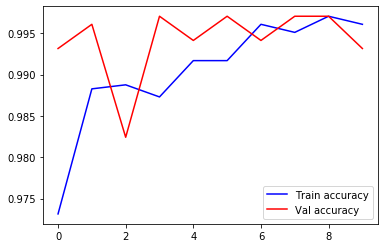

In [30]:
history.plot_acc(0)